## Library

In [6]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from sklearn.neighbors import NearestNeighbors

## Load the saved pickle data

In [7]:
# # Generate random dots
# dots = np.random.rand(3, 10) * 100 # Shape ndot * ndim
#X_C_I_list.pkl
#X_C_I_DinoRing_list.pkl
with open('X_C_I_DinoRing_list.pkl', 'rb') as handle:
    X_C_I_list = pkl.load(handle)
    
X_list = X_C_I_list[0]

X = np.vstack(X_list).squeeze(axis = 2).T


X = X.T
# X is now (n, 3)

X.shape

(32268, 3)

# Apply Kernel K-Means Algorithm

In [8]:
def plot_3d(X):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.scatter3D(X[:,0],X[:,1],X[:,2])
    plt.show()
    
    pass

In [9]:
def kmeans(X, k, threshold, ismean=True):
    print('Starting K-MEANS')
    # K means on euclidean DISTANCE
    if ismean:
        mean_center = np.mean(X, axis = 0)
    else:
        mean_center = np.median(X, axis = 0)
        
    dist_vec = np.sqrt(np.sum(np.square(X-mean_center), axis = 1))

    # Assign k clusters
    cluster_assignments = KMeans(n_clusters=k, random_state=1).fit_predict(dist_vec[:,None])
    
    X_clean_list = []
    for i in range(k):

        X_k = X[np.where(cluster_assignments == i)]

        # Keep points that have at least threshold amount of points
        if len(X_k) >= threshold:
            X_clean_list.append(X_k)

    # Rebuild new points after removing 
    X_clean = np.vstack(X_clean_list)
    print("Points lost: ", len(X) - len(X_clean))
    print("Points remaining:", len(X_clean))
    
    return X_clean

In [10]:
def gaussian(X, ismean=True, alpha = 0.05):
    
    if ismean:
        mean_vec = np.mean(X, axis = 0)
    else:
        mean_vec = np.median(X, axis = 0)
        
    cov_mat = np.cov(X, rowvar = 0)
    
    p = multivariate_normal.cdf(X, mean = mean_vec, cov = cov_mat)

    X_clean = X[np.where((p > alpha) & (p < (1-alpha)))]
    print("Points lost:", len(X) - len(X_clean))
    print("Points remaining:", len(X_clean))
    
    return X_clean
    

In [11]:
def nearestn(X, n_neighbor, n_int = 1, threshold = 0.001):
    print('Starting NN')
    X_clean = X
    
    for i in range(n_int):
        print(i)
        n_before = len(X_clean)
        knc = NearestNeighbors(n_neighbors = n_neighbor)
        knc_fit = knc.fit(X_clean)
        neigh_dist, neigh_ind = knc_fit.kneighbors()
        
        X_clean = X_clean[np.where(neigh_dist < threshold)[0],:]

        n_after = len(X_clean)
        print("Points lost:", n_before - n_after)
    print("Points remaining:", len(X_clean))


    return X_clean



In [12]:
def IQR_test(X):
    
    mean_center = np.mean(X, axis = 0)
    dist_vec = np.sqrt(np.sum(np.square(X-mean_center), axis = 1))
    dist_vec = np.sort(dist_vec)
    
    Q1,Q3 = np.percentile(dist_vec , [25,75])
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)

    X_clean = X[np.where((dist_vec < upper)&(dist_vec > lower))]
    print("Points lost:", len(X) - len(X_clean))
    print("Points remaining:", len(X_clean))
    
    return X_clean
    
    

In [13]:
def gmm_cutoff(X, k, threshold):
    GMM = GaussianMixture(n_components=k, random_state=0).fit(X)
    score = GMM.score_samples(X)
    
    return X[np.where(score > threshold)]

In [14]:
def spatial_cutoff(X, threshold, ifmean = True):

    if ifmean:
        mean_center = np.mean(X, axis = 0)
    else:
        mean_center = np.median(X, axis = 0)

    dist_vec = np.linalg.norm(X - mean_center, axis = 1)
    
    return X[np.where(dist_vec < threshold)]

In [164]:
# X_clean = kmeans(X = X, k = k_kmeans, threshold = threshold_kmeans, ismean = ismean_kmeans)
# X_clean = nearestn(X = X, n_neighbor = n_neighbor, n_int = n_int, threshold = threshold_nn)
# X_clean = gaussian(X = X, ismean = ismean_gaussian)

In [165]:
# KMEANS
k_kmeans = 5
threshold_kmeans = 10
ismean_kmeans = True

# NN
n_neighbor = 1
n_int = 1
threshold_nn = 0.001

# GAUSSIAN
ismean_gaussian = True
alpha = 0.05

<IPython.core.display.Javascript object>


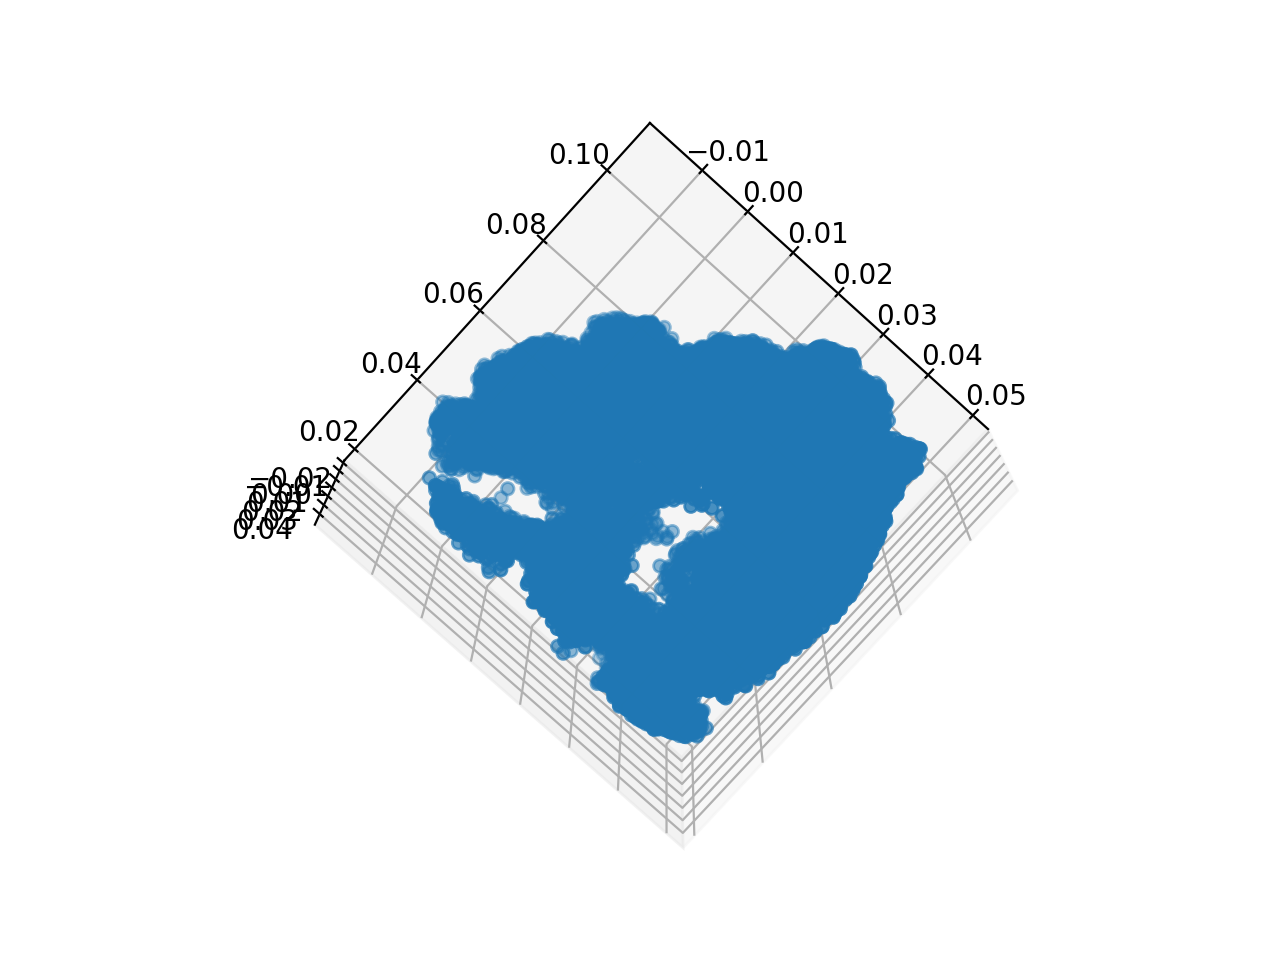

In [174]:
X_clean = spatial_cutoff(X, 0.1)
X_clean = gmm_cutoff(X_clean, 4, 8)

plot_3d(X_clean)

Points lost: 1001
Points remaining: 31267
Starting NN
0
Points lost: 5438
Points remaining: 25829
Starting K-MEANS
Points lost:  0
Points remaining: 25829
Starting NN
0
Points lost: 0
Points remaining: 25829
Points lost: 12995
Points remaining: 12834
Starting K-MEANS
Points lost:  917
Points remaining: 11917
Starting NN
0
Points lost: 81
Points remaining: 11836


<IPython.core.display.Javascript object>


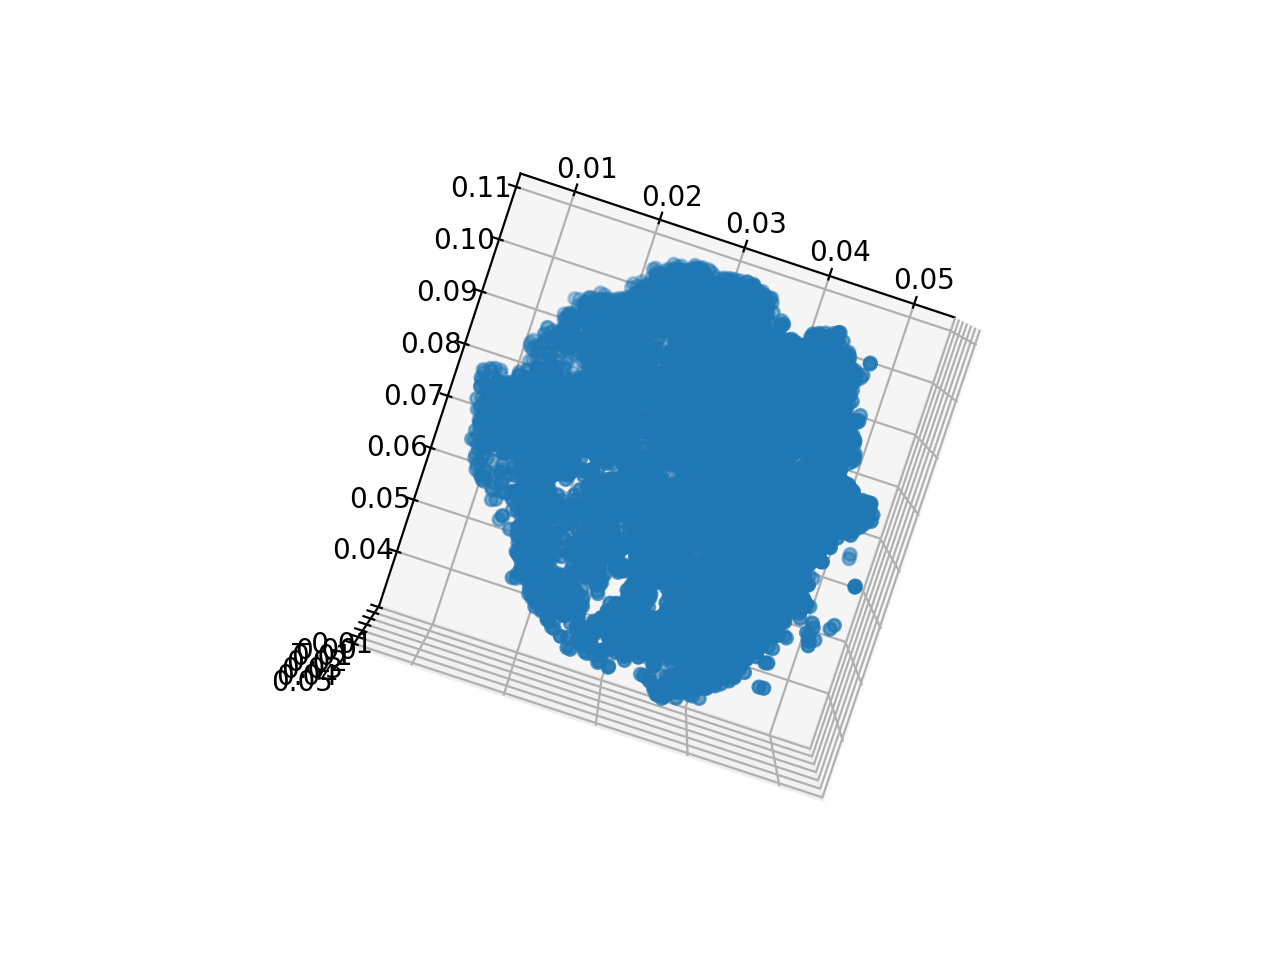

In [172]:
%matplotlib notebook

# Initial X
#     - Bunch of outliers

X_clean = IQR_test(X_clean)
X_clean = nearestn(X = X_clean, n_neighbor = n_neighbor, n_int = n_int, threshold = threshold_nn)
X_clean = kmeans(X = X_clean, k = k_kmeans, threshold = threshold_kmeans, ismean = True)
X_clean = nearestn(X = X_clean, n_neighbor = n_neighbor, n_int = n_int, threshold = 0.002)
X_clean = gaussian(X = X_clean, ismean = False, alpha = 0.1)
X_clean = kmeans(X = X_clean, k = 400, threshold = 20, ismean = False)
X_clean = nearestn(X = X_clean, n_neighbor = n_neighbor, n_int = n_int, threshold = 0.001)


plot_3d(X_clean)


In [155]:
# Median: [0.0257318  0.0575036  0.00860974]]
# Mean: [0.02425855  0.0597834  -0.00086638]

In [156]:
X_clean

array([[ 0.04234043,  0.02544003, -0.00776241],
       [ 0.00788886,  0.02678479, -0.00983007],
       [ 0.00956638,  0.02858472, -0.01376971],
       ...,
       [ 0.04272309,  0.05533834,  0.01644649],
       [ 0.03612717,  0.07430976,  0.00749347],
       [ 0.02356489,  0.06125018, -0.00973928]])

In [175]:
with open('X_clean_array_4.pkl', 'wb') as handle:
    pkl.dump(X_clean, handle, protocol=pkl.HIGHEST_PROTOCOL)

